In [72]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Carregando os dados
train = pd.read_csv('Database/train.csv')
test = pd.read_csv('Database/test.csv')

In [3]:
# Verificando os tipos dos dados.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [4]:
# Variáveis numéricas.
train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [5]:
# Variáveis categóricas.
train.describe(include=['O'])

,Product_ID,Gender,Age,City_Category,Stay_In_Current_City_Years
count,550068,550068,550068,550068,550068
unique,3631,2,7,3,5
top,P00265242,M,26-35,B,1
freq,1880,414259,219587,231173,193821


# Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Distribuição dos valores')

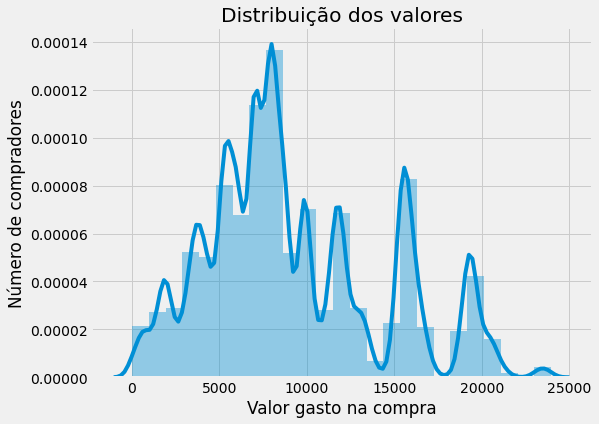

In [6]:
# Começaremos a nossa análise verificando a distribuição da nossa variável alvo (Purchase)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))
sns.distplot(train.Purchase, bins = 25)
plt.xlabel('Valor gasto na compra')
plt.ylabel('Número de compradores')
plt.title('Distribuição dos valores')

Até o momento a única informação que temos é que existe uma maior concentração entre os valores de 5000 a 10000 dólares. Seria mais interessante plotarmos um gráfico de boxplot para uma melhor avaliação da distribuição desses dados, além disso podemos facilmente descobrir se temos outliers.

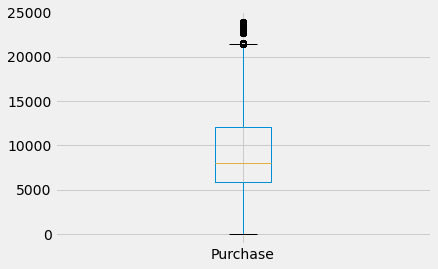

In [7]:
train['Purchase'].plot.box()

E olha só esse gráfico acaba de nos dar uma imformação muito importante, temos outliers na nossa variável alvo. Podemos facilmente afirmar que os valores de compra acima de 20000 dólares são outliers.

# Análise por Sexo

In [8]:
train['Gender'].value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

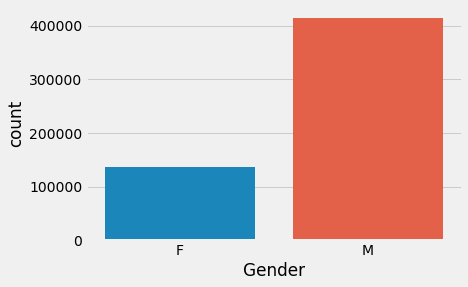

In [9]:
sns.countplot(train.Gender)

In [10]:
# valor médio da compra para cada sexo
train[['Gender','Purchase']].groupby(['Gender'], as_index = True).mean().sort_values(by='Purchase',ascending=False)

,Purchase
Gender,
M,9437.526040
F,8734.565765


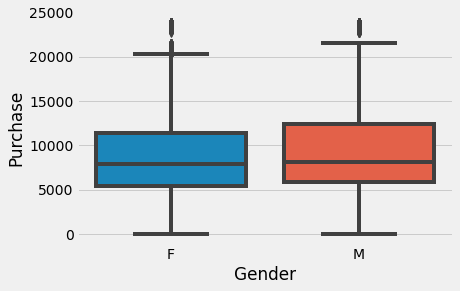

In [11]:
sns.boxplot('Gender', 'Purchase', data=train)

Bom, o que podemos obsevar é que temos um número bem maior de usuários do sexo masculino e que o valor da compra também tende a ser um pouco maior que a do sexo feminino.

# Análise por Idade

In [12]:
train['Age'].value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

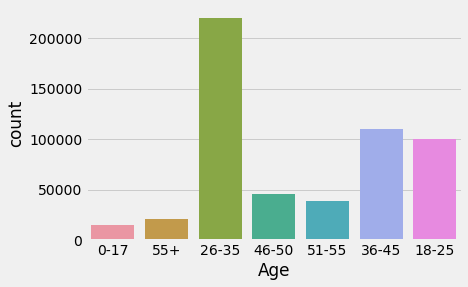

In [13]:
sns.countplot(train.Age)

Observe que a faixa etária entre os usuários se concentra entre 26 a 30 anos, mais ainda não conseguimos saber se nessa faixa etária temos mais homens ou mulheres. O código a seguir agrupa os dados por sexo e faz a contagem dos registros por faixa etária.

In [14]:
train.groupby('Gender')['Age'].value_counts()

Gender  Age  
F       26-35     50752
        36-45     27170
        18-25     24628
        46-50     13199
        51-55      9894
        0-17       5083
        55+        5083
M       26-35    168835
        36-45     82843
        18-25     75032
        46-50     32502
        51-55     28607
        55+       16421
        0-17      10019
Name: Age, dtype: int64

Agora sim podemos dizer que temos mais homens que mulheres na faixa etária de 26 a 30 anos.

In [15]:
# valor médio de compra para cada faixa etária
train[['Age','Purchase']].groupby(['Age'], as_index = True).mean().sort_values(by='Purchase',ascending=False)

,Purchase
Age,
51-55,9534.808031
55+,9336.280459
36-45,9331.350695
26-35,9252.690633
46-50,9208.625697
18-25,9169.663606
0-17,8933.464640


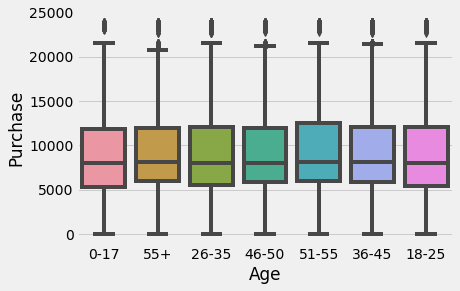

In [16]:
sns.boxplot('Age', 'Purchase', data=train)

O valor médio da compra está bem distribuido entre as idades, com o valor um pouco menor na faixa etária de 0 a 17 anos.

# Análise por Ocupação

In [17]:
train['Occupation'].value_counts()

4     72308
0     69638
7     59133
1     47426
17    40043
20    33562
12    31179
14    27309
2     26588
16    25371
6     20355
3     17650
10    12930
5     12177
15    12165
11    11586
19     8461
13     7728
18     6622
9      6291
8      1546
Name: Occupation, dtype: int64

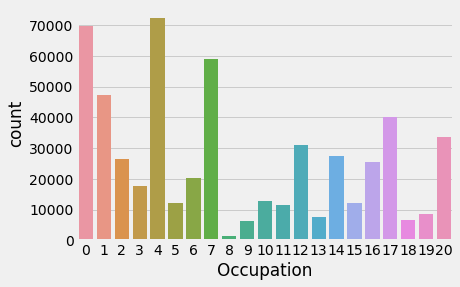

In [18]:
sns.countplot(train.Occupation)

In [19]:
train[['Occupation','Purchase']].groupby(['Occupation'], as_index = True).mean().sort_values(by='Purchase',ascending=False)

,Purchase
Occupation,
17,9821.478236
12,9796.640239
15,9778.891163
8,9532.592497
14,9500.702772
7,9425.728223
16,9394.464349
5,9333.149298
13,9306.351061


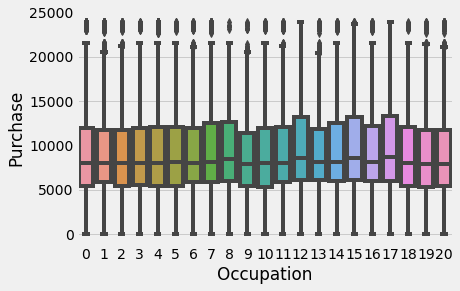

In [20]:
sns.boxplot('Occupation', 'Purchase', data=train)

Temos algumas ocupações com maior concentração de valores, só não sabemos que ocupações são essas, já que a empresa preferiu mascarar essa informação.

# Análise por Cidade

In [21]:
train['City_Category'].value_counts()

B    231173
C    171175
A    147720
Name: City_Category, dtype: int64

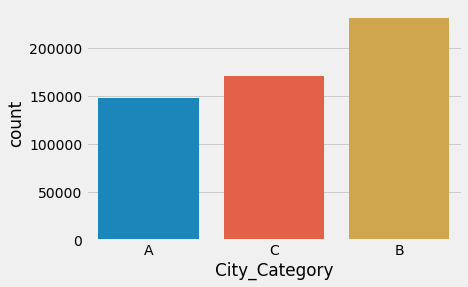

In [22]:
sns.countplot(train.City_Category)

In [23]:
# Média de compra por cidade
train[['City_Category','Purchase']].groupby(['City_Category'], as_index = True).mean().sort_values(by='Purchase',ascending=False)

,Purchase
City_Category,
C,9719.920993
B,9151.300563
A,8911.939216


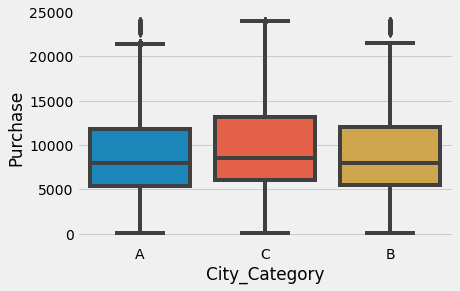

In [24]:
sns.boxplot('City_Category', 'Purchase', data=train)

Chegamos a seguinte conclusão: o maior número de usuários pertence a cidade de categoria B, porém a cidade de categoria C tem o maior valor médio de compra.

# Análise por tempo de moradia na cidade

In [25]:
train['Stay_In_Current_City_Years'].value_counts()

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64

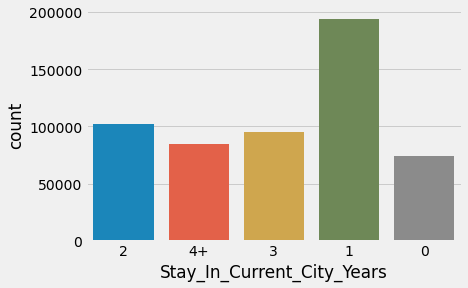

In [26]:
sns.countplot(train.Stay_In_Current_City_Years)

In [27]:
# média do valor da compra de acordo com o número de anos que o usuário mora na cidade atual
train[['Stay_In_Current_City_Years','Purchase']].groupby(['Stay_In_Current_City_Years'], as_index = True).mean().sort_values(by='Purchase',ascending=False)

,Purchase
Stay_In_Current_City_Years,
2,9320.429810
3,9286.904119
4+,9275.598872
1,9250.145923
0,9180.075123


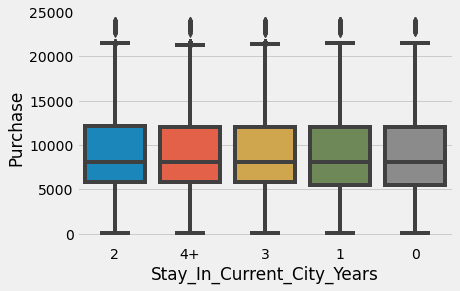

In [28]:
sns.boxplot('Stay_In_Current_City_Years', 'Purchase', data=train)

De acordo com os nossos gráficos os usuários na sua grande maioria moram há 1 ano na cidade atual.

# Análise por estado civil

In [29]:
train['Marital_Status'].value_counts()

0    324731
1    225337
Name: Marital_Status, dtype: int64

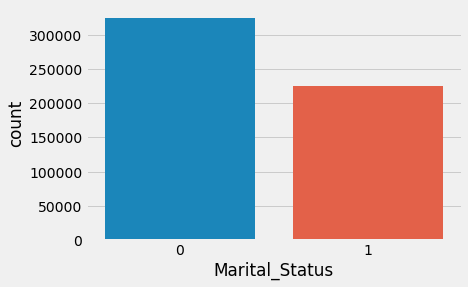

In [30]:
sns.countplot(train.Marital_Status)

In [31]:
# valor médio de compra para cada estado civil
train[['Marital_Status','Purchase']].groupby(['Marital_Status'], as_index = True).mean().sort_values(by='Purchase',ascending=False)

,Purchase
Marital_Status,
0,9265.907619
1,9261.174574


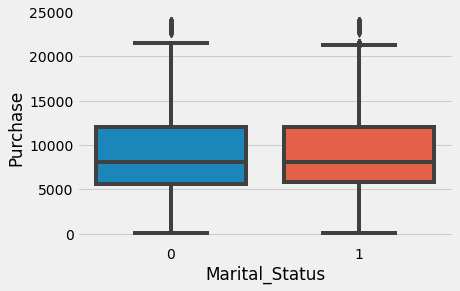

In [32]:
sns.boxplot('Marital_Status', 'Purchase', data=train)

0 não é casado e 1 é casado. Dito isso fica claro que os usuários em sua maioria não são casados.

# Análise por categoria de produto

In [33]:
train['Product_Category_1'].value_counts()

5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: Product_Category_1, dtype: int64

In [34]:
train[['Product_Category_1','Purchase']].groupby(['Product_Category_1'], as_index = True).mean().sort_values(by='Purchase',ascending=True)

,Purchase
Product_Category_1,
19,37.041797
20,370.481176
13,722.400613
12,1350.859894
4,2329.659491
18,2972.864320
11,4685.268456
5,6240.088178
8,7498.958078


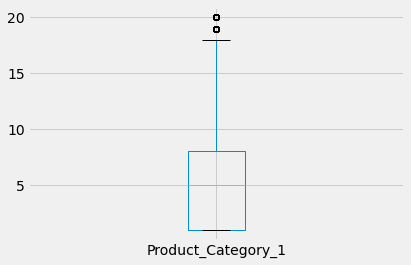

In [35]:
train['Product_Category_1'].plot.box()

Os produtos da categoria 1 que pertencem ao grupo 19 e 20 são outliers.

In [36]:
train['Product_Category_2'].value_counts()

8.0     64088
14.0    55108
2.0     49217
16.0    43255
15.0    37855
5.0     26235
4.0     25677
6.0     16466
11.0    14134
17.0    13320
13.0    10531
9.0      5693
12.0     5528
10.0     3043
3.0      2884
18.0     2770
7.0       626
Name: Product_Category_2, dtype: int64

In [37]:
train[['Product_Category_2','Purchase']].groupby(['Product_Category_2'], as_index = True).mean().sort_values(by='Purchase',ascending=True)

,Purchase
Product_Category_2,
7.0,6884.683706
12.0,6975.472504
14.0,7105.264916
9.0,7277.006851
11.0,8940.580515
5.0,9027.821574
18.0,9352.440433
17.0,9421.576577
13.0,9683.352388


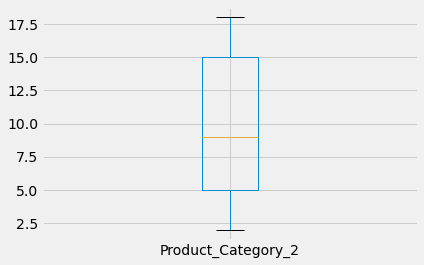

In [38]:
train['Product_Category_2'].plot.box()

Já na categoria 2, temos uma maior quantidade de produtos do grupo 8. Podemos observar também que o produto do grupo 10 teve o maior valor médio de compra.

In [39]:
train['Product_Category_3'].value_counts()

16.0    32636
15.0    28013
14.0    18428
17.0    16702
5.0     16658
8.0     12562
9.0     11579
12.0     9246
13.0     5459
6.0      4890
18.0     4629
4.0      1875
11.0     1805
10.0     1726
3.0       613
Name: Product_Category_3, dtype: int64

In [40]:
train[['Product_Category_3','Purchase']].groupby(['Product_Category_3'], as_index = True).mean().sort_values(by='Purchase',ascending=True)

,Purchase
Product_Category_3,
12.0,8715.512762
4.0,9794.386667
14.0,10052.594530
9.0,10431.697210
18.0,10993.980773
17.0,11769.943001
16.0,11981.890642
11.0,12091.437673
5.0,12117.786889


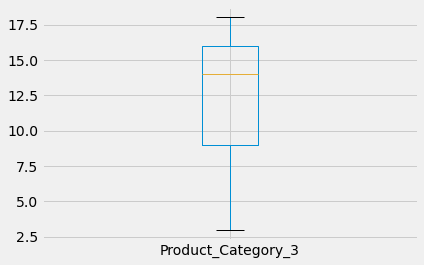

In [41]:
train['Product_Category_3'].plot.box()

Na categoria 3 temos o produto do grupo 3 com a menor quantidade. Dando uma verificada mais detalhada, chegamos a uma informação importante, na categoria 2 e 3 temos um valor médio de compra bem próximo para os produtos do grupo 10.

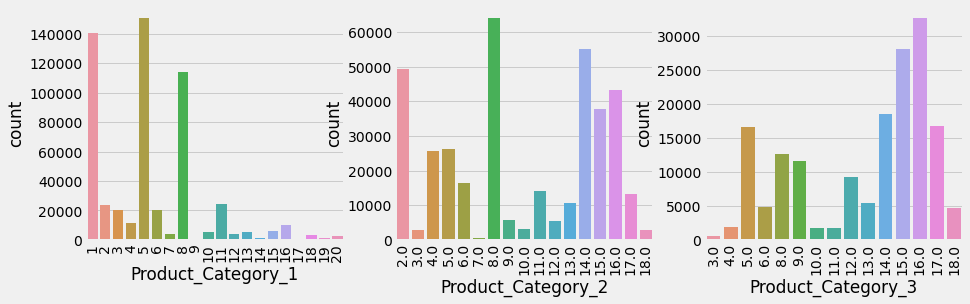

In [42]:
# Distribuição dos valores para cada categoria.
plt.figure(figsize=(14,4))
plt.subplot(131)
sns.countplot(train.Product_Category_1)
plt.xticks(rotation=90)

plt.subplot(132)
sns.countplot(train.Product_Category_2)
plt.xticks(rotation=90)

plt.subplot(133)
sns.countplot(train.Product_Category_3)
plt.xticks(rotation=90)

plt.show()

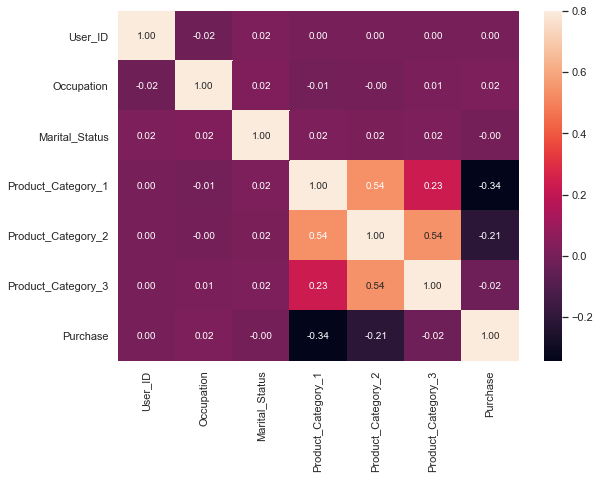

In [43]:
# matriz de correlação
matrix = train.corr()
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
f, ax = plt.subplots(figsize = (8,6))
sns.heatmap(matrix, vmax=.8,annot_kws={'size': 10}, annot=True, fmt='.2f')
plt.show()

Um ponto importante a se observar é a alta correlação entre a categoria dos produtos. Isso já era esperado uma vez que foi dito que um produto pode pertencer a mais de uma categoria.

Meu objetivo principal foi mostrar como podemos extrair importantes informações através de técnicas estatísticas e visualização de dados.
Abaixo vou resumir o que foi descoberto.
- A maioria dos usuários é do sexo masculino
- Com idade entre 26 a 30 anos
- Não são casados
- Residem na cidade de categoria B
- Moram 1 ano na cidade atual
- E compraram mais produtos da categoria 1.

# Criando o Modelo

In [44]:
# Carregando os dados de treino e teste
df_train = pd.read_csv('Database/train.csv')
df_test = pd.read_csv('Database/test.csv')

In [45]:
# Criando o DataFrame de submissão
submission = pd.DataFrame()
submission[['User_ID','Product_ID']] = df_test[['User_ID','Product_ID']]

Durante a análise exploratória de dados (EDA), ficou claro que na coluna 'Product_Category_1' temos dois outliers pontuais, vamos removê-los.

In [46]:
df_train['Product_Category_1'].value_counts()

5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: Product_Category_1, dtype: int64

In [47]:
df_test['Product_Category_1'].value_counts()

5     65017
1     60321
8     48369
2     10192
11    10153
6      8860
3      8578
4      5003
16     4105
15     2694
13     2381
10     2248
12     1663
7      1624
18     1311
14      663
17      223
9       194
Name: Product_Category_1, dtype: int64

Como podemos observar acima só temos esses indíces no dataset de treino, então teremos que removê-los antes de concatenar esses datasets.

In [48]:
# Removendo os outliers do dataset de treino
df_train.drop(df_train[(df_train.Product_Category_1 == 19) | (df_train.Product_Category_1 == 20)].index,inplace=True)

Todas as transformações devem ser feitas em ambos datasets e afim de facilitar esse processo vamos concatena-los sem a variável target(Purchase), assim não precisamos fazer essa tarefa 2 vezes. 


In [49]:
train = df_train
test = df_test

df = pd.concat([train.drop('Purchase', axis=1),test],ignore_index = True, sort = False)
target = train['Purchase']

# Verificando a dimensão dos datasets.
train.shape, test.shape, df.shape

((545915, 12), (233599, 11), (779514, 11))

In [50]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN


Informações sobre as colunas

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779514 entries, 0 to 779513
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     779514 non-null  int64  
 1   Product_ID                  779514 non-null  object 
 2   Gender                      779514 non-null  object 
 3   Age                         779514 non-null  object 
 4   Occupation                  779514 non-null  int64  
 5   City_Category               779514 non-null  object 
 6   Stay_In_Current_City_Years  779514 non-null  object 
 7   Marital_Status              779514 non-null  int64  
 8   Product_Category_1          779514 non-null  int64  
 9   Product_Category_2          537685 non-null  float64
 10  Product_Category_3          237858 non-null  float64
dtypes: float64(2), int64(4), object(5)
memory usage: 65.4+ MB


Verificando a quantidade de valores nulos no dataset.

In [52]:
total = df.isnull().sum().sort_values(ascending=False)
percent = df.isnull().sum()/df.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, sort=False, keys=['total', 'percent'])
missing_data[missing_data['percent']!=0]*100

,total,percent
Product_Category_3,54165600,69.486372
Product_Category_2,24182900,31.023048


Preeenchendo os valores nulos da coluna 'Product_Category_2' e transformando seus valores em inteiro.

In [53]:
df['Product_Category_2'] = df['Product_Category_2'].fillna(-999).astype(int)

Opa! Mais temos duas colunas com valores nulos e só estamos preenchendo uma, isso parece meio estranho. Vamos dar uma olhada nos valores únicos de cada coluna.

In [54]:
df.apply(lambda x: len(x.unique()))

User_ID                       5891
Product_ID                    3672
Gender                           2
Age                              7
Occupation                      21
City_Category                    3
Stay_In_Current_City_Years       5
Marital_Status                   2
Product_Category_1              18
Product_Category_2              18
Product_Category_3              16
dtype: int64

**Podemos observar que a coluna 'Product_Category_3' tem um número menor de valores únicos comparado com as outras duas colunas referentes a categoria do produto. Conforme foi informado na descrição do problema os produtos da categoria 2 e 3 podem pertencer a outra categoria também, mais isso não se aplica aos produtos da categoria  1 que é a categoria principal. Podemos observar que 2 produtos da categoria principal não pertence a categoria 3, então isso pode nos indicar que essa categoria de produtos não Influenciará no valor final da compra.**

Temos vários IDs(1000001,1000002,1000004 - que inclusive se repetem) e cada um 
desses IDs está relacionado com vários produtos.
Vamos verificar a quantidade de usuários por ID e a quantidade de produtos. Para efetuar essa contagem vamos utilizar o **transform** que faz a contagem mais retorna a mesma quantidade de dados diferentemente do aggregate que retorna uma versão reduzida dos dados. Por último vamos ver qual o valor médio de compra de cada produto.

In [55]:
# Número de usuários por ID.
df['User_count'] = df.User_ID.groupby(df.User_ID).transform('count')

# Quantidade de produtos.
df['Product_count'] = df.Product_ID.groupby(df.Product_ID).transform('count')

# Valor médio de compra de cada produto.
df['Product_mean'] = df['Product_ID'].map(target.groupby(train['Product_ID']).mean())
df['Product_mean'] = df['Product_mean'].replace(np.nan, 0)

Transformando os dados da coluna 'Age' em numéricos com a média aritmética entre os valores.

In [56]:
age_dict = {'0-17':17, '18-25':21, '26-35':30, '36-45':40, '46-50':48, '51-55':53, '55+':60}
df["Age"] = df["Age"].apply(lambda x: age_dict[x])

 Na coluna 'Stay_In_Current_City_Years' temos uma string acompanhada de um caracter especial, vamos trocar o valor dessa string por 5 já que ela está como '4+' ao meu ver isso significa que é mais de 4 por isso vou preencher com o valor 5 e transformar seus dados para inteiros.

In [57]:
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].replace('4+', 5).astype(int)

Transformando as variáveis categóricas nominais em numéricas. Estou usando o **drop_first** para evitar o problema de Dummy Variable trap.

In [58]:
df = pd.get_dummies(df, columns=['Gender','City_Category'], drop_first=True)

Visualizando se os dados foram preenchidos corretamente.

In [59]:
df.head()

,User_ID,Product_ID,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,User_count,Product_count,Product_mean,Gender_M,City_Category_B,City_Category_C
0,1000001,P00069042,17,10,2,0,3,-999,NaN,46,344,11870.863436,0,0,0
1,1000001,P00248942,17,10,2,0,1,6,14.0,46,845,16304.030981,0,0,0
2,1000001,P00087842,17,10,2,0,12,-999,NaN,46,150,1237.892157,0,0,0
3,1000001,P00085442,17,10,2,0,12,14,NaN,46,496,1455.140762,0,0,0
4,1000002,P00285442,60,16,5,0,8,-999,NaN,106,283,7692.763547,1,0,1


Agora vamos iremos remover as colunas 'User_ID' e 'Product_ID', pois elas só contém a identificação dos usuários e dos produtos, e a coluna 'Product_Category_3' que como vimos acima não tem uma relação total com a categoria principal e não serão necessárias no nosso modelo.



In [60]:
def remove_features(lista_features):
    for i in lista_features:
        df.drop(i, axis=1, inplace=True)
remove_features(['User_ID','Product_ID','Product_Category_3'])
df.head(n=20)

,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,User_count,Product_count,Product_mean,Gender_M,City_Category_B,City_Category_C
0,17,10,2,0,3,-999,46,344,11870.863436,0,0,0
1,17,10,2,0,1,6,46,845,16304.030981,0,0,0
2,17,10,2,0,12,-999,46,150,1237.892157,0,0,0
3,17,10,2,0,12,14,46,496,1455.140762,0,0,0
4,60,16,5,0,8,-999,106,283,7692.763547,1,0,1
5,30,15,3,0,1,2,41,863,14318.772358,1,0,0
6,48,7,2,1,1,8,14,2066,16899.227083,1,1,0
7,48,7,2,1,1,15,14,826,14169.618887,1,1,0
8,48,7,2,1,1,16,14,1304,15947.346491,1,1,0
9,30,20,1,1,8,-999,151,1139,8068.920555,1,0,0


Verificando se todas as variáveis foram transformadas em numéricas.

In [61]:
df.dtypes

Age                             int64
Occupation                      int64
Stay_In_Current_City_Years      int32
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2              int32
User_count                      int64
Product_count                   int64
Product_mean                  float64
Gender_M                        uint8
City_Category_B                 uint8
City_Category_C                 uint8
dtype: object

Depois de fazer todas as transformações necessárias nos dados
 vamos dividir o dataset em dados de treino e teste novamente.

In [62]:
X_train = df[:545915]
X_test = df[545915:]

Dataset de treino

In [63]:
X_train.head()

,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,User_count,Product_count,Product_mean,Gender_M,City_Category_B,City_Category_C
0,17,10,2,0,3,-999,46,344,11870.863436,0,0,0
1,17,10,2,0,1,6,46,845,16304.030981,0,0,0
2,17,10,2,0,12,-999,46,150,1237.892157,0,0,0
3,17,10,2,0,12,14,46,496,1455.140762,0,0,0
4,60,16,5,0,8,-999,106,283,7692.763547,1,0,1


Dataset de teste

In [64]:
X_test.head()

,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,User_count,Product_count,Product_mean,Gender_M,City_Category_B,City_Category_C
545915,48,7,2,1,1,11,14,1333,15781.118590,1,1,0
545916,30,17,0,0,3,5,84,371,11746.665354,1,0,1
545917,40,1,5,1,5,14,323,217,5731.338028,0,1,0
545918,40,1,5,1,4,9,323,23,1943.266667,0,1,0
545919,30,1,1,0,4,5,109,781,2585.590829,0,0,1


In [65]:
X_train.shape, X_test.shape

((545915, 12), (233599, 12))

In [66]:
target.values

array([ 8370, 15200,  1422, ...,  7852,  7159, 11640], dtype=int64)

#Avaliação dos Algoritmos

Vamos criar pipelines afim de automatizar o processo de treinamento dos nossos modelos e aplicar a **Standartization** (padronização) ao conjunto de dados (colocando-os na mesma escala)
Nesta técnica, os dados serão transformados de modo que estejam com uma distrbuição normal, com média igual a zero e
desvio padrão igual a 1.

In [67]:
pipelines = []
pipelines.append(('Scaled-LR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('Scaled-LASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('Scaled-EN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('Scaled-CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('Scaled-XGBoost', Pipeline([('Scaler', StandardScaler()),('XG', XGBRegressor(objective ='reg:squarederror'))])))
pipelines.append(('Scaled-AB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
pipelines.append(('Scaled-GBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('Scaled-RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
pipelines.append(('Scaled-ET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))
resultados = []
nomes = []

# Percorrendo cada um dos modelos
for nome, modelo in pipelines:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state = 7)
    cross_val_result = model_selection.cross_val_score(modelo, X_train, target, cv = kfold, scoring = 'neg_mean_squared_error')
    resultados.append(cross_val_result)
    nomes.append(nome)
    texto = "%s: %f (%f)" % (nome, np.sqrt(np.abs(cross_val_result)).mean(), np.sqrt(-cross_val_result).std())
    print(texto)

Scaled-LR: 2654.130781 (5.773837)
Scaled-LASSO: 2654.131221 (5.779685)
Scaled-EN: 3002.637471 (7.872833)
Scaled-CART: 3675.495989 (6.420959)
Scaled-XGBoost: 2532.454700 (5.031311)
Scaled-AB: 2775.901181 (6.714100)
Scaled-GBM: 2638.022172 (5.470119)
Scaled-RF: 2621.774947 (7.309424)
Scaled-ET: 2750.631658 (9.444860)


O GradientBoostingRegressor e o XGBRegressor apresentaram a menor taxa de erro entre os modelos

Vamos agora fazer o tuning do modelo utilizando o RandomizedSearchCV, que de acordo com a documentação do scikit-learn tem o tempo de execução  
drasticamente menor que o GridSearchCV. Foi testado vários valores para os parâmetros e deixei aqui só os valores que apareceram com mais frequência (pra ajudar a diminuir o tempo de processamento).

In [68]:
# Definindo a escala
X_train = StandardScaler().fit_transform(X_train)

# Testando valores para o estimador.
valores_grid  = {'n_estimators' : [100,200,300,400], 'max_depth' : [7,9],'min_child_weight': [5,7], 'gamma': [0.1,0.3]}

# Criando o modelo
modelo = XGBRegressor(objective ='reg:squarederror', n_jobs=4)

# Definindo k
kfold = model_selection.KFold(5, True, random_state = 7)

# Testando a combinação de parâmetros
grid = RandomizedSearchCV(modelo, valores_grid, cv = kfold, scoring = 'neg_mean_squared_error')
grid_result = grid.fit(X_train, target)

# Print do resultado
print("Grid scores on development set:")
means = grid.cv_results_['mean_test_score'].round(5)
stds = grid.cv_results_['std_test_score'].round(5)

for mean, std, params in zip((means), stds, grid.cv_results_['params']):
    print(f'mean:{mean},std:{std},params:{params}')
print()
print(f'Melhor parâmetro:{grid.best_params_}, Score:{grid.best_score_}')

Grid scores on development set:
mean:-6221080.50563,std:19478.32632,params:{'n_estimators': 400, 'min_child_weight': 7, 'max_depth': 7, 'gamma': 0.3}
mean:-6235598.37614,std:21512.56102,params:{'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 7, 'gamma': 0.3}
mean:-6317123.81436,std:27102.08451,params:{'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 7, 'gamma': 0.3}
mean:-6336242.33685,std:29225.61669,params:{'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 9, 'gamma': 0.1}
mean:-6322432.83756,std:19416.30256,params:{'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 7, 'gamma': 0.1}
mean:-6216146.79218,std:29782.17069,params:{'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'gamma': 0.3}
mean:-6259148.4456,std:22651.74081,params:{'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 9, 'gamma': 0.1}
mean:-6273264.05019,std:23318.12932,params:{'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 9, 'gamma': 0.3}
mean:-6259148.4456,std:22

**É claro que não me deixei levar pelas vantagens do XGBRegressor e também fiz o tuning do  GradientBoostingRegressor, e de fato obtive uma melhor pontuação com o XGBRegressor. 
Como o processo é um pouco demorado optei por mostrar somente um dos processos.**

In [70]:
# Preparando a versão final do modelo
X_train = StandardScaler().fit_transform(X_train)
modelo_xbg =  XGBRegressor(objective ='reg:squarederror', n_estimators = 300,
                                                          min_child_weight=5,
                                                          max_depth=7, 
                                                          gamma=0.3, 
                                                          random_state=7,
                                                          n_jobs=4)
                                                          
modelo_xbg.fit(X_train, target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.3, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=7, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=7, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [71]:
# Aplicando o modelo aos dados de teste
X_test = StandardScaler().fit_transform(X_test)
previsoes = modelo_xbg.predict(X_test)

In [73]:
# Visualizando os resultados
submission['User_ID','Product_ID'] = np.around(previsoes,2)
submission = submission.rename(columns={('User_ID','Product_ID'):'Purchase'})
submission.head()

,User_ID,Product_ID,Purchase
0,1000004,P00128942,14001.639648
1,1000009,P00113442,11548.700195
2,1000010,P00288442,6633.149902
3,1000010,P00145342,2725.350098
4,1000011,P00053842,2849.929932


In [74]:
# Submissão
submission.to_csv("sample_submission.csv", index=False)